In [1]:
import os
import numpy as np
import pandas as pd
from nltk.corpus import stopwords   
import nltk
from tqdm import tqdm
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from attention import AttentionLayer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
import re
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 1. Cargamos los datos

In [2]:
path_, filename_, category_, article_or_summary_,content_ = [],[],[],[],[]
for dirname, _, filenames in os.walk('data/'):
    for filename in filenames:
        path = os.path.join(dirname, filename).replace("\\","/")
        f = open(os.path.join(dirname, filename),"r")
        try:
            article = str(f.read())
            article = article.replace("\\n",'')
            # Remove all excepth the alphabets
            article = re.sub("[^a-zA-Z0-9]",' ', article)
            content_.append(article)
            path_.append(path)
            filename_.append(filename)
            category_.append(path.split("/")[-2])
            article_or_summary_.append(path.split("/")[-3])
        except:
            print("ERROR ABRIENDO EL FICHERO")

        

In [3]:
df = pd.DataFrame({"path":path_, "filename":filename_, "category":category_, "article_or_summary":article_or_summary_,"content":content_}, columns=["path", "filename", "category", "article_or_summary","content"])
df

,path,filename,category,article_or_summary,content
0,data/News Articles/business/001.txt,001.txt,business,News Articles,Ad sales boost Time Warner profit Quarterly p...
1,data/News Articles/business/002.txt,002.txt,business,News Articles,Dollar gains on Greenspan speech The dollar h...
2,data/News Articles/business/003.txt,003.txt,business,News Articles,Yukos unit buyer faces loan claim The owners ...
3,data/News Articles/business/004.txt,004.txt,business,News Articles,High fuel prices hit BA s profits British Air...
4,data/News Articles/business/005.txt,005.txt,business,News Articles,Pernod takeover talk lifts Domecq Shares in U...
...,...,...,...,...,...
4443,data/Summaries/tech/397.txt,397.txt,tech,Summaries,BT is introducing two initiatives to help beat...
4444,data/Summaries/tech/398.txt,398.txt,tech,Summaries,A third of them read unsolicited junk e mail a...
4445,data/Summaries/tech/399.txt,399.txt,tech,Summaries,This goes to the heart of the European project...
4446,data/Summaries/tech/400.txt,400.txt,tech,Summaries,Amit Yoran was director of the National Cyber ...


## 2. Limpiamos los textos de las noticias y los resumenes

In [4]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [5]:
## Definimos funciones de limpiezoa
stop_words = set(stopwords.words('english')) 
def text_cleaner(text):
    article = text.lower()
    article = re.sub(r'\([^)]*\)', '', article)
    article = re.sub('"','', article)
    article = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in article.split(" ")])    
    article = re.sub(r"'s\b","",article)
    article = re.sub("[^a-zA-Z]", " ", article) 
    tokens = [w for w in article.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:          
            long_words.append(i)   
    return (" ".join(long_words)).strip()
def summary_cleaner(text):
    summary = re.sub('"','', text)
    summary = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in summary.split(" ")])    
    summary = re.sub(r"'s\b","",summary)
    summary = re.sub("[^a-zA-Z]", " ", summary)
    summary = summary.lower()
    tokens=summary.split()
    summary=''
    for i in tokens:
        if len(i)>1:                                 
            summary=summary+i+' '  
    summary = 'sostok ' + summary + 'eostok'
    return summary


In [6]:
data = df[df["article_or_summary"]=="News Articles"]
cleaned_text = []
for t in data['content']:
    cleaned_text.append(text_cleaner(t))
data = df[df["article_or_summary"]=="Summaries"]
cleaned_summary = []
for t in data['content']:
    cleaned_summary.append(summary_cleaner(t))


### Limitamos el tamaño de las noticias. Vamos a ver cuanto puede ser el limite

In [23]:
cnt=0
th = 350
for i in cleaned_text:
    if(len(i.split()) <= th):
        cnt=cnt+1
print(f"El {100*cnt/len(cleaned_text)} % de las noticias tiene menos de {th} valores")

El 91.00719424460432 % de las noticias tiene menos de 350 valores


### Lo mismo pero para los resumenes

In [7]:
cnt=0
th = 100
for i in cleaned_summary:
    if(len(i.split()) <= th):
        cnt=cnt+1
print(f"El {100*cnt/len(cleaned_text)} % de los resumenes tiene menos de {th} valores")

El 21.987410071942445 % de los resumenes tiene menos de 100 valores


Finalmente fijamos longitud maxima de noticias a 350 y de resumenes a 200

In [8]:
max_text_len=350
max_summary_len = 100

### Separamos en train y test (85-15%)

In [9]:
from sklearn.model_selection import train_test_split

x_tr,x_val,y_tr,y_val=train_test_split(np.array(cleaned_text), np.array(cleaned_summary),
                                       test_size=0.15, random_state=0, shuffle=True) 

### Vemos cuáles las palabras raras, aquellas que aparecen pocas veces. Lo suyo será quitarlas del tokenizador porque no aportan mucho.
Hemos decidido que la definición de rara es que aparezca menos de 5 veces en total

In [10]:
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))
thresh=5
cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print(f"Las palabras raras son un {cnt/tot_cnt*100}% del total, siendo un {(freq/tot_freq)*100} del texto")

Las palabras raras son un 63.493788819875775% del total, siendo un 7.240811574505508 del texto


In [11]:
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))
thresh=5
cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print(f"Las palabras raras son un {cnt/tot_cnt*100}% del total, siendo un {(freq/tot_freq)*100} del texto")

Las palabras raras son un 67.19959890813882% del total, siendo un 6.675486326876537 del texto


### Tokenizamos las noticias y los resumenes

In [29]:
### NOTICIAS

# En el tokenizer quitamos las palabras raras
x_tokenizer = Tokenizer(num_words=tot_cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

# Tenemos que meter el padding para las noticias cortas
x_tr    =   pad_sequences(x_tokenizer.texts_to_sequences(x_tr) ,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_tokenizer.texts_to_sequences(x_val), maxlen=max_text_len, padding='post')

# El tamaño del vocabulario
x_voc   =  x_tokenizer.num_words + 1

In [30]:
### RESUMENES

y_tokenizer = Tokenizer(num_words=tot_cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

# Tenemos que meter el padding para los resumenes cortos
y_tr    =   pad_sequences(y_tokenizer.texts_to_sequences(y_tr) , maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_tokenizer.texts_to_sequences(y_val) , maxlen=max_summary_len, padding='post')

# El tamaño del vocabulario
y_voc  =   y_tokenizer.num_words +1

### Creamos el modelo de redes neuronales, formado por un encoder y un decoder

#### Encoder. Se utilizan 3 LSTM consecutivas

In [31]:
latent_dim = 300
embedding_dim=100

encoder_inputs = Input(shape=(max_text_len,))

# Capa de embeddings
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#Lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#Lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#Lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

Decoder. Usamos una capa de atención definida en el archivo attention.py

In [33]:
decoder_inputs = Input(shape=(None,))


dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
#attn_layer = AttentionLayer(name='attention_layer') 
#attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

#decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# Dense Layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

In [34]:
# Definimos el modelo
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary() 

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 30, 100)   │  1,795,200 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ [(None, 30, 300), │    481,200 │ embedding_2[0][0] │
│                     │ (None, 300),      │            │                   │
│                     │ (None, 300)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ [(None, 30, 300), │    721,200 │ lstm_4[0][0]      │
│                     │ (None, 300),      │            │                   │
│                     │ (None, 300)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, None, 100) │  1,795,200 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ [(None, 30, 300), │    721,200 │ lstm_5[0][0]      │
│                     │ (None, 300),      │            │                   │
│                     │ (None, 300)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_8 (LSTM)       │ [(None, None,     │    481,200 │ embedding_4[0][0… │
│                     │ 300), (None,      │            │ lstm_6[0][1],     │
│                     │ 300), (None,      │            │ lstm_6[0][2]      │
│                     │ 300)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, None,      │  5,403,552 │ lstm_8[0][0]      │
│ (TimeDistributed)   │ 17952)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 11,398,752 (43.48 MB)

 Trainable params: 11,398,752 (43.48 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [36]:
history=model.fit([x_tr, y_tr[:,:-1]], 
                  y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:,1:],
                  epochs=50,
                  callbacks=[es],
                  batch_size=128, 
                  validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:])
                 )

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 777ms/step - loss: 9.7612 - val_loss: 8.1537
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 730ms/step - loss: 7.5602 - val_loss: 6.8391
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 804ms/step - loss: 6.7974 - val_loss: 6.7303
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 787ms/step - loss: 6.6396 - val_loss: 6.6537
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 778ms/step - loss: 6.5650 - val_loss: 6.6649
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 763ms/step - loss: 6.4990 - val_loss: 6.6028
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 765ms/step - loss: 6.4509 - val_loss: 6.6717
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - loss: 6.4146 - val_loss: 6.5986
Epoch 9/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 932ms/step - loss: 6.3866 - val_loss: 6.6288
Epoch 10/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 937ms/step - loss: 6.3605 - val_loss: 6.5790
Epoch 11/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 955ms/step - loss: 6.3280 - val_loss: 6.6502
Epoch 12/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 9

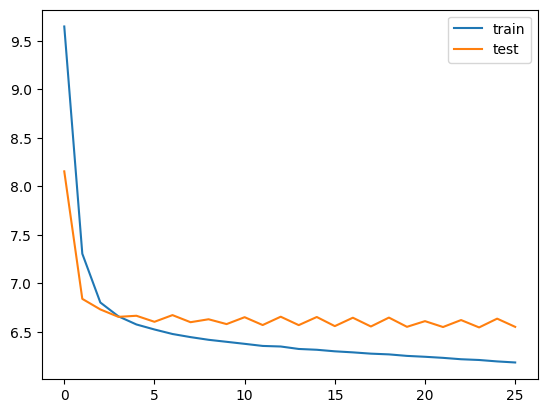

In [37]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

## Inferencia

In [38]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [ ]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
#attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
#decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index+1]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
for i in range(0, 2):
    print("News:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

News: england match holland earlier month action four six weeks bad challenge said villa boss david leary able tell whether need operation maybe next week whether operation got left chelsea cole also struggled ankle problem earlier season unable rest leary return fitness four months broken ankle moore villa manager problems department 
Original summary: action for four to six weeks after bad challenge said villa boss david leary 
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms